## Understanding Light Fields in SPECTRA 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy

from cartopy.util import add_cyclic_point
from mpl_toolkits.basemap import Basemap

In [2]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
PAR_avg_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid_SPECTRA_PAR_avg*.nc', recursive=True))
ds= xr.open_mfdataset(PAR_avg_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [6]:
ds.PAR_avg

<xarray.DataArray 'PAR_avg' (time: 756, z_t_150m: 15, lat: 180, lon: 360)>
dask.array<concatenate, shape=(756, 15, 180, 360), dtype=float32, chunksize=(12, 15, 180, 360)>
Coordinates:
  * lon       (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * z_t_150m  (z_t_150m) float32 500.0 1500.0 2500.0 ... 12500.0 13500.0 14500.0
  * time      (time) object 0062-02-01 00:00:00 ... 0125-01-01 00:00:00
Attributes:
    long_name:     PAR Average over Model Cell
    units:         W/m^2
    grid_loc:      3114
    cell_methods:  time: mean

In [11]:
lats = [87.5,78.5,84.5, 75.5, 84.5];
lons = [-20,50, -80, -169, 150];

# longitude in degrees East
AO_lon1 = np.where(ice_ds.lon == -20)
AO_lon2 = np.where(ice_ds.lon == 50)
AO_lon3 = np.where(ice_ds.lon == -70)
AO_lon4 = np.where(ice_ds.lon == -169)
AO_lon5 = np.where(ice_ds.lon == 150)
# Latitude degrees_north
AO_lat1 = np.where(ice_ds.lat == 87.5) # The one closes to the arctic circle
AO_lat2 = np.where(ice_ds.lat == 83.5) # The one far away close to the red 
AO_lat3 = np.where(ice_ds.lat == 83.5) # The one under the most ice 
AO_lat4 = np.where(ice_ds.lat == 75.5) # The one far away cose to green. 
AO_lat5 = np.where(ice_ds.lat == 84.5) # The one similar to 1 in ice thickness

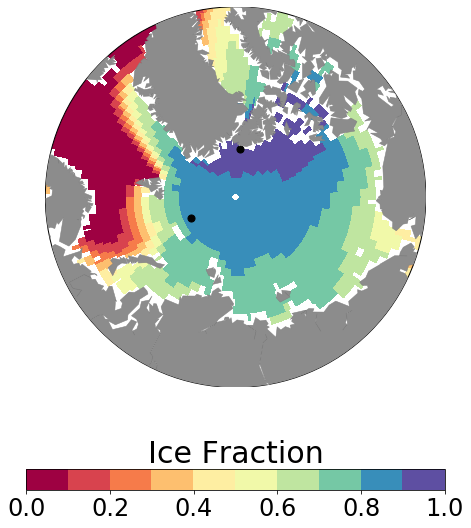

In [10]:
import matplotlib.patches as mpatches
fig = plt.figure(figsize=(10, 10))
lat = ice_ds.lat
ax = fig.add_subplot(1, 1, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
ice, lon = add_cyclic_point(np.nanmean(ice_ds.ECOSYS_IFRAC,axis=0), coord=ice_ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,lat))
cf = m.pcolormesh(x,y,ice,shading='flat',cmap=plt.cm.get_cmap('Spectral', 10),vmin = 0, vmax=1) 
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.55', lake_color=None, ax=None, zorder=None, alpha=None)
cb = plt.colorbar(cf,shrink=0.75, orientation='horizontal')
cb.ax.set_title('Ice Fraction', fontsize = 30)
cb.ax.tick_params(labelsize=24)

# make up some data for scatter plot
lats = [83.5,83.5];
lons = [50, -70];
x,y = m(lons, lats) # transform coordinates 
plt.scatter(x,y,50,marker='o', color='Black'); 
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/ice_fraction_AO_'+year+'year.png', dpi=600, bbox_inches='tight')

In [15]:
AO_lon2[0]

array([230])

In [14]:
AO_lat2[0]

array([173])

## Light depth profile

In [18]:
par_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_2ndcycle_20year_clim_remap/regrid_'+new_file+'_PAR_avg.*.nc', recursive=True))
par_ds = xr.open_mfdataset(par_inds,combine='by_coords')

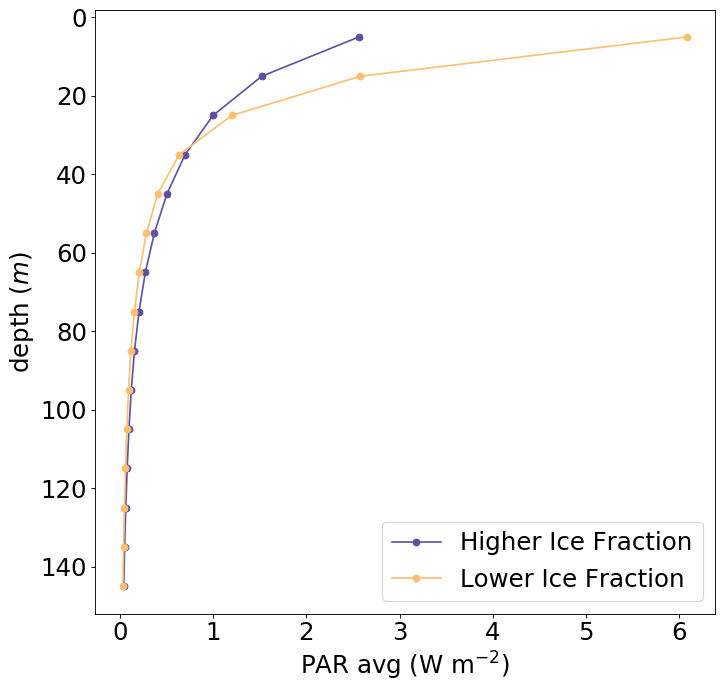

In [19]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(np.nanmean(par_ds.PAR_avg[:,:,173,110],axis=0),par_ds.z_t_150m/100, '-o', color=cmap(9),label='Higher Ice Fraction')
pylab.plot(np.nanmean(par_ds.PAR_avg[:,:,173,230],axis=0),par_ds.z_t_150m/100, '-o',color=cmap(3),label='Lower Ice Fraction')


pylab.legend(loc='lower right', fontsize=22)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('PAR avg (W m$^{-2}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/PAR_avg_depth_profile'+year+'year.png', dpi=600, bbox_inches='tight')

## Now Let's check between the difference in September compared to March, and with this general averaged one

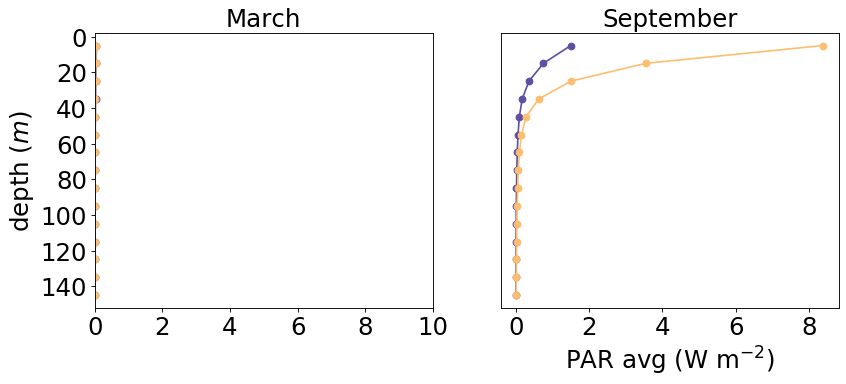

In [24]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(2, 2, 1)
pylab.plot(par_ds.PAR_avg[2,:,173,110],par_ds.z_t_150m/100, '-o', color=cmap(9),label='Higher Ice Fraction')
pylab.plot(par_ds.PAR_avg[2,:,173,230],par_ds.z_t_150m/100, '-o',color=cmap(3),label='Lower Ice Fraction')
#pylab.legend(loc='lower right', fontsize=22)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.title('March', fontsize=22)
#pylab.xlabel('PAR avg (W m$^{-2}$)', fontsize=22)
plt.yticks(fontsize= 22);
plt.xlim([0,10])
plt.xticks([0,2,4,6,8,10],fontsize= 22);
pylab.gca().invert_yaxis()

ax = fig.add_subplot(2, 2, 2)
pylab.plot(par_ds.PAR_avg[8,:,173,110],par_ds.z_t_150m/100, '-o', color=cmap(9),label='Ice Thick')
pylab.plot(par_ds.PAR_avg[8,:,173,230],par_ds.z_t_150m/100, '-o',color=cmap(3),label='Ice Free')
pylab.title('September', fontsize=22)
pylab.xlabel('PAR avg (W m$^{-2}$)', fontsize=22)
plt.xticks(fontsize= 22);
plt.tick_params(
    axis='y',      
    left=False,
    labelleft =False)      
pylab.gca().invert_yaxis()

#ax = fig.add_subplot(3, 3, 3)
#pylab.plot(np.nanmean(par_ds.PAR_avg[:,:,173,110],axis=0),par_ds.z_t_150m/100, '-o', color=cmap(9),label='Ice Thick')
#pylab.plot(np.nanmean(par_ds.PAR_avg[:,:,173,230],axis=0),par_ds.z_t_150m/100, '-o',color=cmap(3),label='Ice Free')
#pylab.legend(loc='lower right', fontsize=10)
#pylab.title('Annual', fontsize=22)
#pylab.xlabel('PAR avg (W m$^{-2}$)', fontsize=22)
#plt.xlim([0,10])
#plt.xticks([0,2,4,6,8,10],fontsize= 22);
#plt.xticks(fontsize= 22);
#plt.tick_params(
#    axis='y',      
#    left=False,
#    labelleft =False)      
#pylab.gca().invert_yaxis()


pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/PAR_avg_depth_profile_MSA_'+year+'year.png', dpi=600, bbox_inches='tight')

## Primary Production 

In [25]:
ppC_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_ppC.*.nc', recursive=True))
ppC_ds = xr.open_mfdataset(ppC_inds,combine='by_coords')
mp1C_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_mp1C.*.nc', recursive=True))
mp1C_ds = xr.open_mfdataset(mp1C_inds,combine='by_coords')
mp2C_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_mp2C.*.nc', recursive=True))
mp2C_ds = xr.open_mfdataset(mp2C_inds,combine='by_coords')
mp3C_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_mp3C.*.nc', recursive=True))
mp3C_ds = xr.open_mfdataset(mp3C_inds,combine='by_coords')
mp4C_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_mp4C.*.nc', recursive=True))
mp4C_ds = xr.open_mfdataset(mp4C_inds,combine='by_coords')
diazC_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_diazC.*.nc', recursive=True))
diazC_ds = xr.open_mfdataset(diazC_inds,combine='by_coords')
diat1C_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_diat1C.*.nc', recursive=True))
diat1C_ds = xr.open_mfdataset(diat1C_inds,combine='by_coords')
diat2C_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_diat2C.*.nc', recursive=True))
diat2C_ds = xr.open_mfdataset(diat2C_inds,combine='by_coords')
diat3C_inds = sorted(glob.glob('/glade/scratch/gabyn/GNG595_20yrclim/regrid_GNG595_diat3C.*.nc', recursive=True))
diat3C_ds = xr.open_mfdataset(diat3C_inds,combine='by_coords')

In [26]:
phytoC = np.stack([ppC_ds.ppC, mp1C_ds.mp1C, diazC_ds.diazC, 
                               mp2C_ds.mp2C, diat1C_ds.diat1C, diat2C_ds.diat2C, 
                               mp3C_ds.mp3C, diat3C_ds.diat3C, mp4C_ds.mp4C]) # mmol/m^3
phytoC_bm = np.sum(phytoC, axis=0) # mmol/m^3

In [27]:
phytoC_bm.shape

(12, 15, 180, 360)

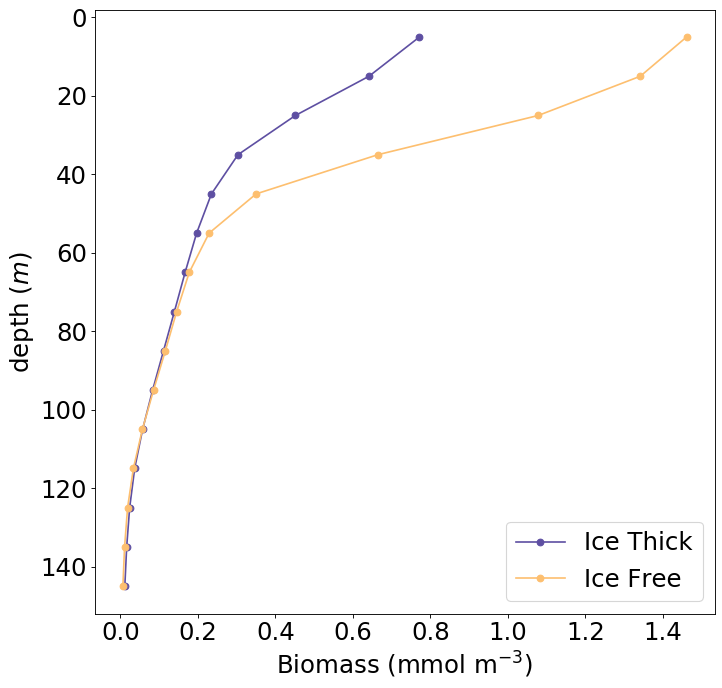

In [28]:
import matplotlib
cmap=matplotlib.cm.get_cmap('Spectral', 10)
fig = figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
pylab.plot(np.nanmean(phytoC_bm[:,:,173,110],axis=0),par_ds.z_t_150m/100, '-o', color=cmap(9),label='Ice Thick')
pylab.plot(np.nanmean(phytoC_bm[:,:,173,230],axis=0),par_ds.z_t_150m/100, '-o',color=cmap(3),label='Ice Free')


pylab.legend(loc='lower right', fontsize=22)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.xlabel('Biomass (mmol m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
pylab.gca().invert_yaxis()
pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Biomass_depth_profile'+year+'year.png', dpi=600, bbox_inches='tight')

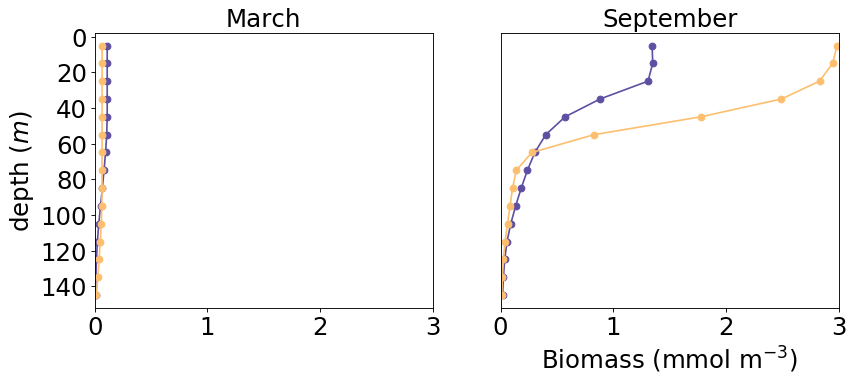

In [29]:
cmap=matplotlib.cm.get_cmap('Spectral', 10)
fig = figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(2, 2, 1)
pylab.plot(phytoC_bm[2,:,173,110],par_ds.z_t_150m/100, '-o', color=cmap(9),label='Ice Thick')
pylab.plot(phytoC_bm[2,:,168,230],par_ds.z_t_150m/100, '-o',color=cmap(3),label='Ice Free')
#pylab.legend(loc='lower right', fontsize=22)
pylab.ylabel('depth ($m$)', fontsize=22)
pylab.title('March', fontsize=22)
#pylab.xlabel('Biomass (mmol m$^{-3}$)', fontsize=22)
plt.yticks(fontsize= 22);plt.xticks(fontsize= 22);
plt.xlim([0,3])
plt.xticks([0,1,2,3],fontsize= 22);
pylab.gca().invert_yaxis()

ax = fig.add_subplot(2, 2, 2)
pylab.plot(phytoC_bm[8,:,173,110],par_ds.z_t_150m/100, '-o', color=cmap(9),label='Ice Thick')
pylab.plot(phytoC_bm[8,:,168,230],par_ds.z_t_150m/100, '-o',color=cmap(3),label='Ice Free')
pylab.title('September', fontsize=22)
pylab.xlabel('Biomass (mmol m$^{-3}$)', fontsize=22)
plt.xticks(fontsize= 22);
plt.xlim([0,3])
plt.xticks([0,1,2,3],fontsize= 22);
plt.tick_params(
    axis='y',      
    left=False,
    labelleft =False)      
pylab.gca().invert_yaxis()

#ax = fig.add_subplot(2, 2, 3)
#pylab.plot(np.nanmean(phytoC_bm[:,:,173,110],axis=0),par_ds.z_t_150m/100, '-o', color=cmap(9),label='Ice Thick')
#pylab.plot(np.nanmean(phytoC_bm[:,:,168,230],axis=0),par_ds.z_t_150m/100, '-o',color=cmap(3),label='Ice Free')
#pylab.legend(loc='lower right', fontsize=10)
#pylab.title('Annual', fontsize=22)
#pylab.xlabel('Biomass (mmol m$^{-3}$)', fontsize=22)
#plt.xlim([0,3])
#plt.xticks([0,1,2,3],fontsize= 22);
#plt.tick_params(
#    axis='y',      
#    left=False,
#    labelleft =False)      
#pylab.gca().invert_yaxis()


pylab.show()
fig.tight_layout()
fig.savefig('/glade/u/home/gabyn/case_notes/analysis_figures/'+new_file+'/Biomass_depth_profile_MSA_'+year+'year.png', dpi=600, bbox_inches='tight')